# **Insurance Claim Prediction**

**Description:** This notebook builds a clean, reproducible pipeline to predict insurance claim outcomes. We engineer time-based and ratio features, standardize numeric variables, and train robust models for claim severity and frequency with proper handling of skew (winsorization) and aligned preprocessing for deployment.

**Targets**
- **LC**: Loss Cost (X.15 / X.16)  
- **HALC**: Historically Adjusted Loss Cost (LC × X.18)  
- **CS**: Claim Status (1 if X.16 > 0 else 0)

**Models**
- **LC & HALC:** XGBoost (Tweedie objective, capped at 99th percentile for stability)  
- **CS:** RandomForestClassifier

# **Part A – Data Prep**


In [1]:
# Consolidate imports and setup
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split # Import train_test_split
from sklearn.preprocessing import StandardScaler # Import StandardScaler
from xgboost import XGBRegressor # Import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier # Import RandomForestRegressor and RandomForestClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score # Import evaluation metrics


# Setup
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

# Mount Google Drive
try:
    drive.mount('/content/drive')
except:
    print("Google Drive already mounted or not in Colab environment.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Define file paths
TRAIN_PATH = '/content/drive/MyDrive/DSO 530/data/insurance_train.csv'
TEST_PATH  = '/content/drive/MyDrive/DSO 530/data/insurance_test.csv'

print(f"TRAIN_PATH: {TRAIN_PATH}")
print(f"TEST_PATH: {TEST_PATH}")

TRAIN_PATH: /content/drive/MyDrive/DSO 530/data/insurance_train.csv
TEST_PATH: /content/drive/MyDrive/DSO 530/data/insurance_test.csv


In [3]:
def parse_dates(df: pd.DataFrame, date_cols: list) -> pd.DataFrame:
    """Converts specified columns in a DataFrame to datetime objects."""
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], dayfirst=True)
    return df

def engineer_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """Derives time-based features from date columns."""
    df['insured_age'] = (df['X.2'] - df['X.5']).dt.days / 365.25
    df['license_age'] = (df['X.2'] - df['X.6']).dt.days / 365.25
    df['days_to_next_renewal'] = (df['X.4'] - df['X.2']).dt.days
    return df

def build_targets(df: pd.DataFrame) -> pd.DataFrame:
    """Calculates target variables (LC, HALC, CS) and handles infinities/NaNs."""
    df['LC']   = df['X.15'] / df['X.16']
    df['HALC'] = df['LC'] * df['X.18']
    df['CS']   = (df['X.16'] > 0).astype(int)

    # Replace infinite values with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill NaNs in LC and HALC with 0
    df['LC'].fillna(0, inplace=True)
    df['HALC'].fillna(0, inplace=True)

    return df

In [4]:
# 1. Load the training data
df_train = pd.read_csv(TRAIN_PATH)

# 2. Load the test data
df_test = pd.read_csv(TEST_PATH)

# 3. Add is_train column
df_train['is_train'] = 1
df_test['is_train'] = 0

# 4. Concatenate the dataframes
df_combined = pd.concat([df_train, df_test], ignore_index=True)

# 5. Define date columns
date_cols = ['X.2', 'X.3', 'X.4', 'X.5', 'X.6']

# 6. Apply parse_dates function
df_combined = parse_dates(df_combined, date_cols)

# 7. Apply engineer_time_features function
df_combined = engineer_time_features(df_combined)

# 8. Define engineered ratio columns and create them
# Note: X.14, X.23, X.25, X.26, X.28 are already in the dataframe
# We add policy_year, vehicle_age, value_to_power_ratio, premium_to_value_ratio, doors_per_weight
df_combined['policy_year'] = df_combined['X.2'].dt.year
df_combined['vehicle_age'] = df_combined['policy_year'] - df_combined['X.22']
# Handle potential division by zero or zero values in X.23, X.25, X.28
df_combined['value_to_power_ratio'] = df_combined['X.25'].replace(0, np.nan) / df_combined['X.23'].replace(0, np.nan)
df_combined['premium_to_value_ratio'] = df_combined['X.14'].replace(0, np.nan) / df_combined['X.25'].replace(0, np.nan)
df_combined['doors_per_weight'] = df_combined['X.26'].replace(0, np.nan) / df_combined['X.28'].replace(0, np.nan)

# 9. Apply build_targets function (will create LC, HALC, CS and handle NaNs/Infs)
df_combined = build_targets(df_combined)

# 10. Separate the combined DataFrame back into train and test
df_train_processed = df_combined[df_combined['is_train'] == 1].drop(columns=['is_train']).copy()
df_test_submission_processed = df_combined[df_combined['is_train'] == 0].drop(columns=['is_train', 'LC', 'HALC', 'CS']).copy() # Drop targets from test

# 11. Separate the target variables from the training data
y_lc_train_full = df_train_processed['LC'].copy()
y_halc_train_full = df_train_processed['HALC'].copy()
y_cs_train_full = df_train_processed['CS'].copy()

# 12. Drop the original target columns from the training features
df_train_processed = df_train_processed.drop(columns=['LC', 'HALC', 'CS'])


# 13. Define columns to drop (original dates and raw claim/ID columns)
cols_to_drop_raw = date_cols + ['X.1','X.15','X.16','X.18']

# Drop these columns from both processed dataframes
df_train_processed = df_train_processed.drop(columns=cols_to_drop_raw)
df_test_submission_processed = df_test_submission_processed.drop(columns=cols_to_drop_raw)


# 14. Identify categorical columns (excluding the one-hot encoded ones created later)
# These are the original categorical columns that need encoding
cat_cols = ['X.7','X.13','X.19','X.20','X.21','X.27']


# 15. Perform one-hot encoding
df_train_processed = pd.get_dummies(df_train_processed, columns=cat_cols, drop_first=True)
df_test_submission_processed = pd.get_dummies(df_test_submission_processed, columns=cat_cols, drop_first=True)

# Align columns - crucial for consistent feature sets between train and test
train_cols = df_train_processed.columns
test_cols = df_test_submission_processed.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    df_test_submission_processed[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    df_train_processed[c] = 0

# Ensure the order of columns is the same
df_test_submission_processed = df_test_submission_processed[train_cols]


# 16. Display the shapes
print("Shape of processed training features:", df_train_processed.shape)
print("Shape of processed submission test features:", df_test_submission_processed.shape)


Shape of processed training features: (37451, 29)
Shape of processed submission test features: (15787, 29)


## Implement visualization helper functions



In [5]:
def plot_hist(df, column, title, xlabel, ylabel, kde=True):
    """Generates a histogram for a given column."""
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=kde)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='both', alpha=0.3)
    plt.show()

def plot_scatter(df, x_col, y_col, title, xlabel, ylabel, alpha=0.2, marker='o'):
    """Generates a scatter plot for two columns."""
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_col], df[y_col], marker, alpha=alpha)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.5)
    plt.show()

print("Plotting helper functions defined.")

Plotting helper functions defined.


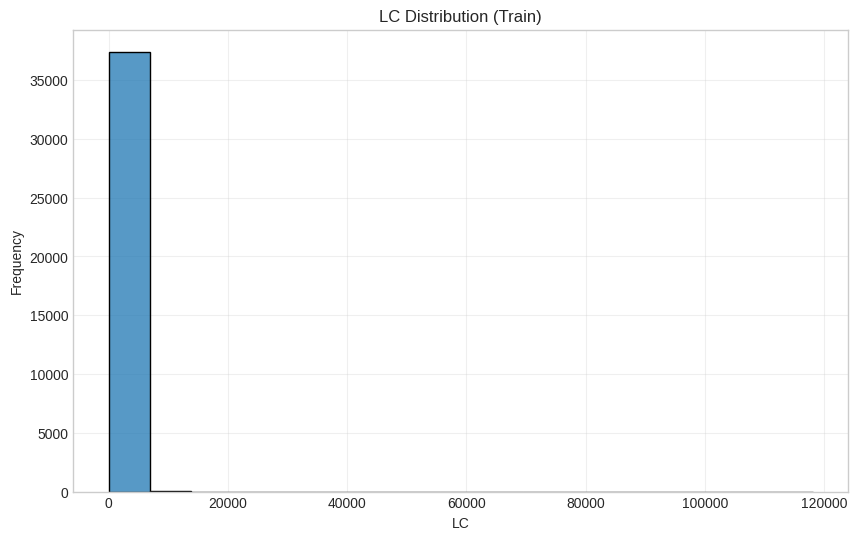

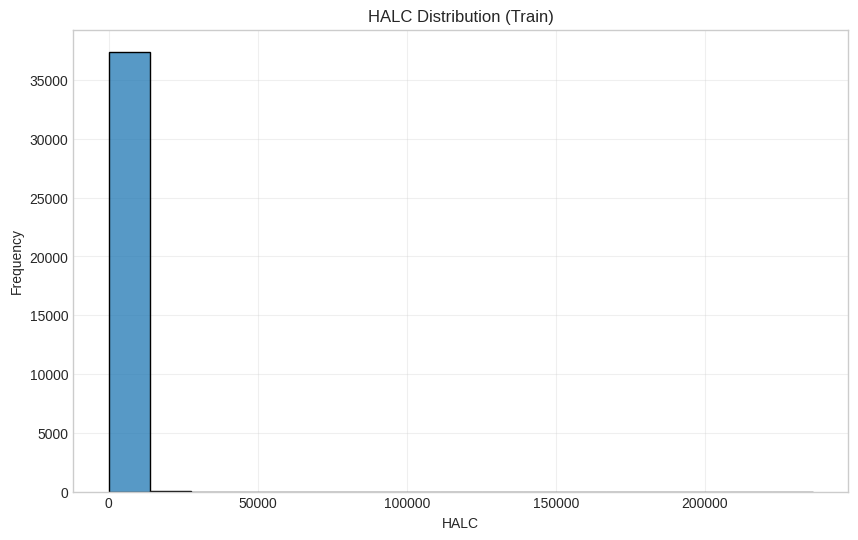

In [6]:
# Plot LC distribution using the full training LC series
plot_hist(pd.DataFrame(y_lc_train_full), y_lc_train_full.name, 'LC Distribution (Train)', 'LC', 'Frequency', kde=False)
# Plot HALC distribution using the full training HALC series
plot_hist(pd.DataFrame(y_halc_train_full), y_halc_train_full.name, 'HALC Distribution (Train)', 'HALC', 'Frequency', kde=False)

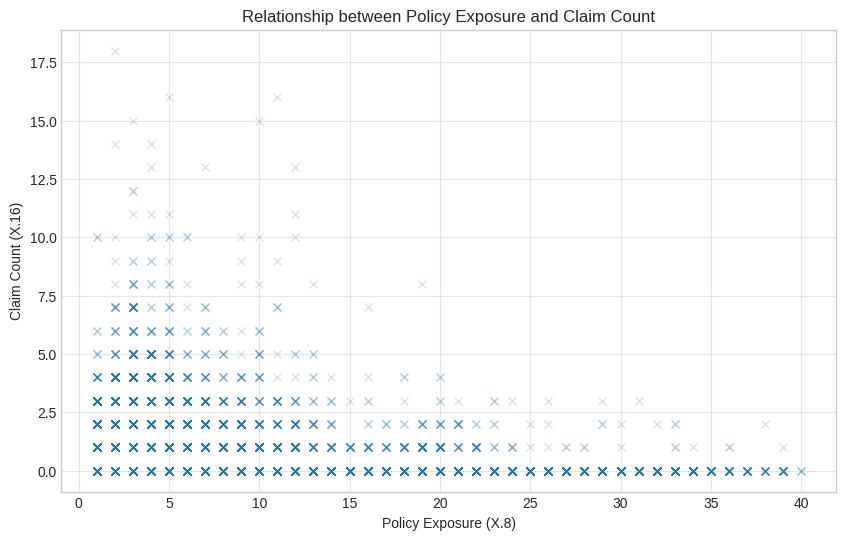

In [7]:
# Use the original df for X.8 and X.16 as these columns were not dropped in the initial steps
plot_scatter(df_combined, 'X.8', 'X.16', 'Relationship between Policy Exposure and Claim Count', 'Policy Exposure (X.8)', 'Claim Count (X.16)', alpha=0.2, marker='x')



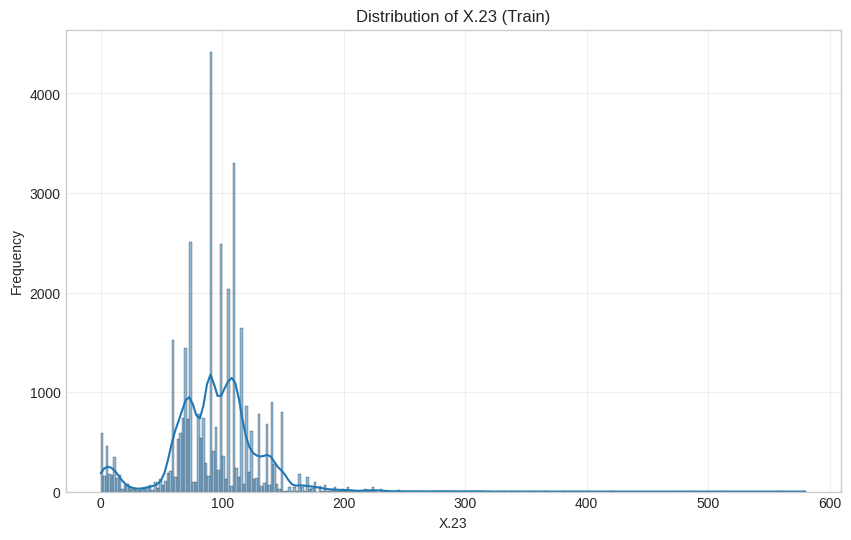

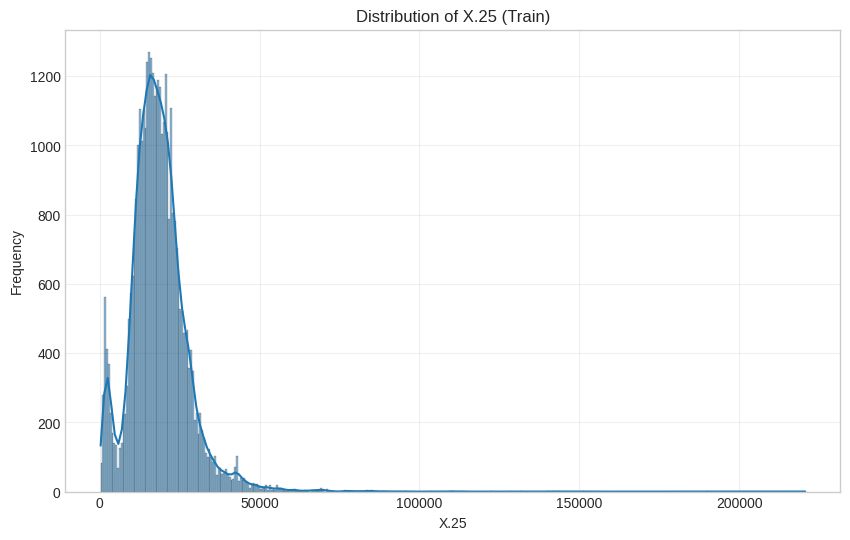

In [8]:
# Use df_train_processed which contains X.23 after preprocessing
plot_hist(df_train_processed, 'X.23', 'Distribution of X.23 (Train)', 'X.23', 'Frequency', kde=True)

# Use df_train_processed which contains X.25 after preprocessing
plot_hist(df_train_processed, 'X.25', 'Distribution of X.25 (Train)', 'X.25', 'Frequency', kde=True)

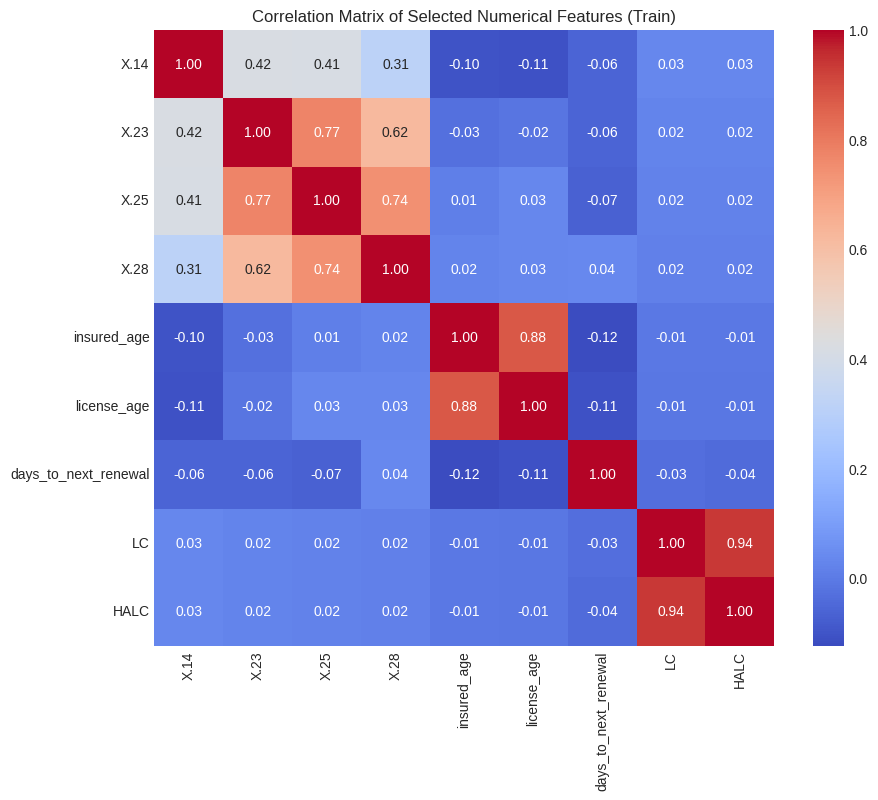

In [9]:
# Define the specific columns to include in the correlation matrix
selected_cols = ["X.14", "X.23", "X.25", "X.28", "insured_age", "license_age", "days_to_next_renewal", "LC", "HALC"]

df_train_with_targets = df_train_processed.copy()
df_train_with_targets['LC'] = y_lc_train_full # Use full training targets
df_train_with_targets['HALC'] = y_halc_train_full # Use full training targets

# Select only the specified columns
df_selected_numeric = df_train_with_targets[selected_cols]

# Compute the correlation matrix
correlation_matrix_selected = df_selected_numeric.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_selected, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Numerical Features (Train)')
plt.show()

# **Part B – Modeling Baseline**


In [10]:
# Step 7 – Split processed training data into evaluation train and test sets
print("\nStep 7: Split processed training data into evaluation train and test sets")
# This split is for evaluating different model approaches during development
X_train, X_test, y_lc_train, y_lc_test, y_halc_train, y_halc_test, y_cs_train, y_cs_test = train_test_split(
    df_train_processed, # Use the fully processed training data
    y_lc_train_full, y_halc_train_full, y_cs_train_full,
    test_size=0.20,
    random_state=42
)

print("Processed training data split into evaluation train and test sets.")
print("Shapes after splitting:")
print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_lc_train:", y_lc_train.shape)
print("y_lc_test: ", y_lc_test.shape)
print("y_halc_train:", y_halc_train.shape)
print("y_halc_test: ", y_halc_test.shape)
print("y_cs_train:", y_cs_train.shape)
print("y_cs_test: ", y_cs_test.shape)

# Step 8 – Scale numeric features and impute NaNs/Infs consistently
print("\nStep 8: Scale numeric features and impute NaNs/Infs consistently")

# Identify continuous columns - use the columns from the training split
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

# Impute infinities/NaNs with training medians *before* scaling
print("Imputing infinite and NaN values with training medians...")
for col in num_cols:
    # Replace infinite values with NaN first
    X_train[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_test_submission_processed[col].replace([np.inf, -np.inf], np.nan, inplace=True) # Impute submission test set too

    # Calculate median only on the training data after replacing infinities
    median_val = X_train[col].median()

    # Fill NaNs with the calculated median
    X_train[col].fillna(median_val, inplace=True)
    X_test[col].fillna(median_val, inplace=True)
    df_test_submission_processed[col].fillna(median_val, inplace=True) # Use training median for test set

print("Imputation complete.")


# Create scaler and fit on the training data
print("\nScaling numeric features...")
scaler = StandardScaler()

# Scale training, evaluation test, and submission data
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()
X_test_submission_scaled = df_test_submission_processed.copy() # Start with submission features


X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])
X_test_submission_scaled[num_cols] = scaler.transform(df_test_submission_processed[num_cols])


print("Scaling complete.")
print("First 5 rows of scaled training features:")
display(X_train_scaled[num_cols].head())
print("\nFirst 5 rows of scaled evaluation test features:")
display(X_test_scaled[num_cols].head())
print("\nFirst 5 rows of scaled submission test features:")
display(X_test_submission_scaled[num_cols].head())

#Archive of Optional/Exploratory Models
#--- Step 9: Train baseline models & evaluate performance (Random Forest) ---
print("\nStep 9: Train baseline models (Random Forest) & evaluate performance")
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score

# 1. Random Forest for LC
print("\nTraining baseline Random Forest for LC...")
rf_lc = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_lc.fit(X_train_scaled, y_lc_train)
print("Baseline Random Forest for LC training complete.")

# 2. Random Forest for HALC
print("\nTraining baseline Random Forest for HALC...")
rf_halc = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_halc.fit(X_train_scaled, y_halc_train)
print("Baseline Random Forest for HALC training complete.")

# 3. Random Forest classifier for CS
print("\nTraining baseline Random Forest classifier for CS...")
rf_cs = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_cs.fit(X_train_scaled, y_cs_train)
print("Baseline Random Forest classifier for CS training complete.")

# --- Evaluate ---
print("\n--- Evaluating Baseline Random Forest Models ---")

# LC
pred_lc = rf_lc.predict(X_test_scaled)
rmse_lc = np.sqrt(mean_squared_error(y_lc_test, pred_lc))
print(f"Baseline Random Forest LC RMSE: {rmse_lc:.2f}")

# HALC
pred_halc = rf_halc.predict(X_test_scaled)
rmse_halc = np.sqrt(mean_squared_error(y_halc_test, pred_halc))
print(f"Baseline Random Forest HALC RMSE: {rmse_halc:.2f}")

# CS
proba_cs = rf_cs.predict_proba(X_test_scaled)[:, 1]
auc_cs = roc_auc_score(y_cs_test, proba_cs)
print(f"Baseline Random Forest CS ROC-AUC: {auc_cs:.3f}")



Step 7: Split processed training data into evaluation train and test sets
Processed training data split into evaluation train and test sets.
Shapes after splitting:
X_train: (29960, 29)
X_test:  (7491, 29)
y_lc_train: (29960,)
y_lc_test:  (7491,)
y_halc_train: (29960,)
y_halc_test:  (7491,)
y_cs_train: (29960,)
y_cs_test:  (7491,)

Step 8: Scale numeric features and impute NaNs/Infs consistently
Imputing infinite and NaN values with training medians...
Imputation complete.

Scaling numeric features...
Scaling complete.
First 5 rows of scaled training features:


,X.8,X.9,X.10,X.11,X.12,X.14,X.17,X.22,X.23,X.24,...,X.26,X.28,insured_age,license_age,days_to_next_renewal,policy_year,vehicle_age,value_to_power_ratio,premium_to_value_ratio,doors_per_weight
28035,-0.303203,-0.497469,-0.702022,-0.238319,1.110747,-0.019492,-0.159668,0.625734,0.184759,-0.418331,...,-0.713858,-0.584705,-0.642107,-0.839243,0.048720,0.086386,-0.548235,-0.955402,0.115363,-0.440987
22882,-0.814169,0.472665,0.115126,-0.238319,1.110747,0.348353,3.219176,0.185088,-0.031035,-0.204307,...,0.616398,0.291446,-0.335082,-0.204257,-0.756152,0.868531,0.289027,1.266547,-0.412791,0.148250
23598,-0.814169,-0.497469,-0.702022,-0.238319,-0.692546,0.986762,-0.679491,1.947671,0.427528,-0.199291,...,-0.713858,0.246516,0.822665,1.180866,-0.756152,0.868531,-1.385498,0.448386,-0.192460,-1.403474
23295,-0.643847,0.472665,0.115126,-0.238319,-0.692546,-0.247723,-0.679491,-0.108676,-0.084983,0.633395,...,0.616398,0.271228,1.044275,1.436584,-0.488106,0.607816,0.428571,-0.144534,-0.267325,0.175511
3427,0.378085,0.472665,0.932275,-0.238319,1.110747,4.335261,1.659709,1.213261,1.344653,-0.033757,...,0.616398,0.291446,0.394723,0.603124,0.048720,0.086386,-1.106410,-0.524685,0.926968,0.148250



First 5 rows of scaled evaluation test features:


,X.8,X.9,X.10,X.11,X.12,X.14,X.17,X.22,X.23,X.24,...,X.26,X.28,insured_age,license_age,days_to_next_renewal,policy_year,vehicle_age,value_to_power_ratio,premium_to_value_ratio,doors_per_weight
2830,-0.473525,2.412931,1.749423,3.604537,-0.692546,-0.776521,-0.419579,-3.633841,-2.512668,-1.455008,...,-2.709243,-2.231422,1.381422,1.629533,-0.488106,0.607816,3.777620,-0.124430,-0.322098,0.036187
20893,-0.132881,-0.497469,-0.702022,-0.238319,1.110747,0.100721,0.620065,-0.255558,-0.894212,-0.629010,...,0.616398,-0.708265,0.442057,-0.587061,0.316766,-0.174329,0.149483,-0.506409,0.597846,2.167760
8634,-0.473525,-0.497469,-0.702022,-0.238319,-0.692546,-0.560484,-0.419579,0.331970,1.344653,0.630051,...,-0.713858,0.268981,0.104909,0.458136,-0.487371,-0.174329,-0.408692,-0.285685,-0.628307,-1.421941
24413,-0.643847,-0.497469,-0.702022,-0.238319,-0.692546,-0.584180,-0.159668,-0.843085,-0.084983,-0.052150,...,0.616398,-0.252217,1.555267,1.574500,-0.488106,0.607816,1.126289,-0.647193,-0.242123,1.039687
5843,-0.473525,0.472665,0.115126,-0.238319,-0.692546,-0.055521,-0.419579,0.331970,1.533473,0.623363,...,0.616398,1.347322,-0.457290,-0.510588,-0.756152,0.868531,0.149483,0.608702,-0.670085,-0.894401



First 5 rows of scaled submission test features:


,X.8,X.9,X.10,X.11,X.12,X.14,X.17,X.22,X.23,X.24,...,X.26,X.28,insured_age,license_age,days_to_next_renewal,policy_year,vehicle_age,value_to_power_ratio,premium_to_value_ratio,doors_per_weight
37451,-0.643847,0.472665,0.115126,-0.238319,1.110747,-0.551407,-0.419579,-0.255558,0.589374,0.487926,...,0.616398,0.257748,-0.757430,-1.241054,-0.488106,0.607816,0.568114,-0.806514,-0.356491,0.193893
37452,-0.643847,-0.497469,-0.702022,-0.238319,1.110747,0.329992,-0.419579,-0.843085,-0.084983,-0.035429,...,0.616398,-0.240984,1.930281,2.189373,-0.487371,0.086386,0.847202,-0.710325,0.272342,1.017238
37453,-0.814169,2.412931,1.749423,3.604537,-0.692546,-0.197074,-0.419579,-0.255558,1.344653,0.885876,...,0.616398,0.684591,1.241571,1.515267,-0.756152,0.868531,0.707658,0.703122,-0.689622,-0.316576
37454,-0.132881,-0.497469,-0.702022,-0.238319,-0.692546,-0.118225,-0.419579,-0.989967,-0.894212,0.113384,...,0.616398,-0.404982,0.724340,0.985265,0.316766,-0.174329,0.847202,0.042393,0.135141,1.367056
37455,-0.473525,-0.497469,-0.702022,-0.238319,1.110747,0.089774,-0.419579,1.507025,-0.732366,-1.036993,...,0.616398,-0.577966,-1.211837,-1.037054,-0.219326,0.086386,-1.385498,-0.321613,0.319681,1.795363



Step 9: Train baseline models (Random Forest) & evaluate performance

Training baseline Random Forest for LC...
Baseline Random Forest for LC training complete.

Training baseline Random Forest for HALC...
Baseline Random Forest for HALC training complete.

Training baseline Random Forest classifier for CS...
Baseline Random Forest classifier for CS training complete.

--- Evaluating Baseline Random Forest Models ---
Baseline Random Forest LC RMSE: 919.78
Baseline Random Forest HALC RMSE: 1511.60
Baseline Random Forest CS ROC-AUC: 0.917


# **Part D – Final Models & Insights**

In [11]:
# Step 18 – Retrain Final Models on Full Training Data & Predict on Submission Test
print("\nStep 18: Retrain Final Models on Full Training Data & Predict on Submission Test")

# Select best models: Capped XGBoost for LC/HALC, Random Forest for CS
# Parameters for Capped XGBoost (from Step 17 evaluation)
best_params_xgb_final = {
    'objective':'reg:tweedie',
    'tweedie_variance_power':1.5,
    'n_estimators':500,
    'learning_rate':0.01,
    'max_depth':6,
    'subsample':1.0,
    'colsample_bytree':0.8,
    'gamma':1,
    'reg_alpha':0.5,
    'reg_lambda':5,
    'random_state':42,
    'n_jobs':-1
}

# 1. Retrain Capped XGBoost for LC on full training data
print("\nRetraining Capped XGBoost for LC on full training data...")
cap_lc_full = np.percentile(y_lc_train_full, 99) # Cap based on the full training target
y_lc_train_full_clip = np.clip(y_lc_train_full, None, cap_lc_full)

xgb_lc_final = XGBRegressor(**best_params_xgb_final)
xgb_lc_final.fit(df_train_processed, y_lc_train_full_clip)
print("Capped XGBoost for LC (final) training complete.")

# 2. Retrain Capped XGBoost for HALC on full training data
print("\nRetraining Capped XGBoost for HALC on full training data...")
cap_halc_full = np.percentile(y_halc_train_full, 99) # Cap based on the full training target
y_halc_train_full_clip = np.clip(y_halc_train_full, None, cap_halc_full)

xgb_halc_final = XGBRegressor(**best_params_xgb_final)
xgb_halc_final.fit(df_train_processed, y_halc_train_full_clip)
print("Capped XGBoost for HALC (final) training complete.")

# 3. Retrain Random Forest Classifier for CS on full training data
print("\nRetraining Random Forest Classifier for CS on full training data...")
rf_cs_final = RandomForestClassifier(random_state=42, n_jobs=-1) # Using default RF as it performed well for CS
rf_cs_final.fit(df_train_processed, y_cs_train_full)
print("Random Forest Classifier for CS (final) training complete.")


# 4. Predict on the scaled submission test set
print("\nMaking predictions on the submission test set...")
lc_pred_submission   = xgb_lc_final.predict(X_test_submission_scaled)
halc_pred_submission = xgb_halc_final.predict(X_test_submission_scaled)
cs_pred_submission   = rf_cs_final.predict(X_test_submission_scaled)
print("Predictions on submission test set complete.")


# Step 19 – Evaluate Final Models on Evaluation Test Set
print("\nStep 19: Evaluate Final Models on Evaluation Test Set")

# Calculate and print final evaluation metrics using the evaluation test set
print("\n--- Final Model Evaluation Metrics (on Evaluation Test Set) ---")

# LC RMSE (on capped evaluation test target)
# Ensure y_lc_test_clip_eval is defined and consistent with evaluation split capping
cap_lc_eval = np.percentile(y_lc_train, 99) # Recalculate cap based on evaluation train if needed
y_lc_test_clip_eval = np.clip(y_lc_test, None, cap_lc_eval)
pred_lc_eval = xgb_lc_final.predict(X_test_scaled) # Predict on scaled evaluation test set
rmse_lc_final = np.sqrt(mean_squared_error(y_lc_test_clip_eval, pred_lc_eval))
print(f"Final Capped XGB Tweedie LC RMSE (Evaluation Test): {rmse_lc_final:.2f}")

# HALC RMSE (on capped evaluation test target)
# Ensure y_halc_test_clip_eval is defined and consistent with evaluation split capping
cap_halc_eval = np.percentile(y_halc_train, 99) # Recalculate cap based on evaluation train if needed
y_halc_test_clip_eval = np.clip(y_halc_test, None, cap_halc_eval)
pred_halc_eval = xgb_halc_final.predict(X_test_scaled) # Predict on scaled evaluation test set
rmse_halc_final = np.sqrt(mean_squared_error(y_halc_test_clip_eval, pred_halc_eval))
print(f"Final Capped XGB Tweedie HALC RMSE (Evaluation Test): {rmse_halc_final:.2f}")

# CS ROC-AUC
proba_cs_eval = rf_cs_final.predict_proba(X_test_scaled)[:, 1] # Predict probabilities on scaled evaluation test set
auc_cs_final = roc_auc_score(y_cs_test, proba_cs_eval)
print(f"Final Random Forest CS ROC-AUC (Evaluation Test): {auc_cs_final:.3f}")


# Step 20 – Generate Submission CSV
print("\nStep 20: Generate Submission CSV")

submission = pd.DataFrame({
    'LC':   lc_pred_submission,
    'HALC': halc_pred_submission,
    'CS':   cs_pred_submission.astype(int)
})

# Save the submission file
submission_path = '/content/Prediction.csv'
submission.to_csv(submission_path, index=False)
print(f"✔️ Submission file saved successfully to {submission_path}")



Step 18: Retrain Final Models on Full Training Data & Predict on Submission Test

Retraining Capped XGBoost for LC on full training data...
Capped XGBoost for LC (final) training complete.

Retraining Capped XGBoost for HALC on full training data...
Capped XGBoost for HALC (final) training complete.

Retraining Random Forest Classifier for CS on full training data...
Random Forest Classifier for CS (final) training complete.

Making predictions on the submission test set...
Predictions on submission test set complete.

Step 19: Evaluate Final Models on Evaluation Test Set

--- Final Model Evaluation Metrics (on Evaluation Test Set) ---
Final Capped XGB Tweedie LC RMSE (Evaluation Test): 180.38
Final Capped XGB Tweedie HALC RMSE (Evaluation Test): 329.10
Final Random Forest CS ROC-AUC (Evaluation Test): 0.603

Step 20: Generate Submission CSV
✔️ Submission file saved successfully to /content/Prediction.csv



Feature Importance Analysis

Getting feature importances for Capped XGBoost (LC)...


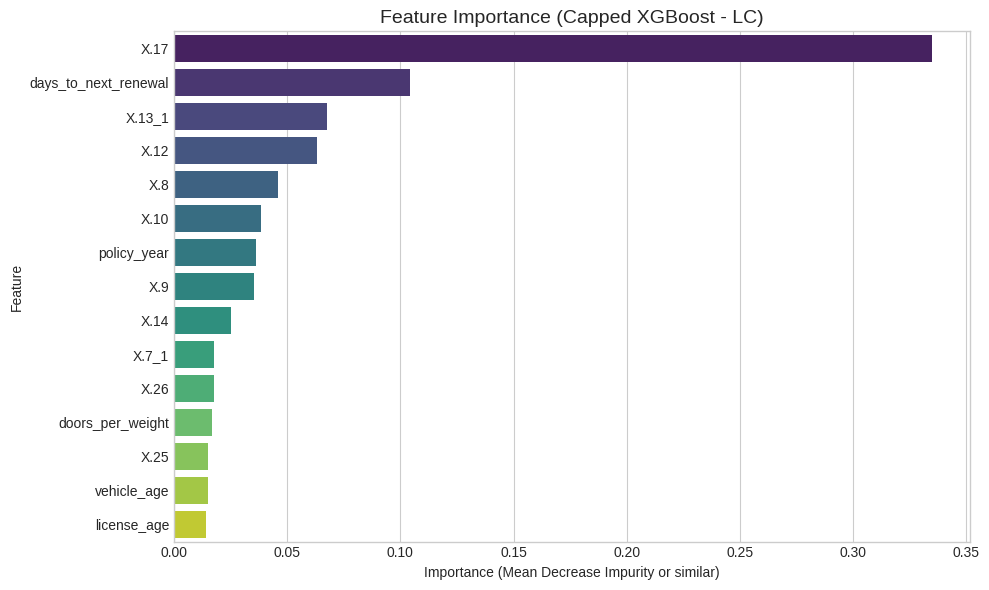


Getting feature importances for Capped XGBoost (HALC)...


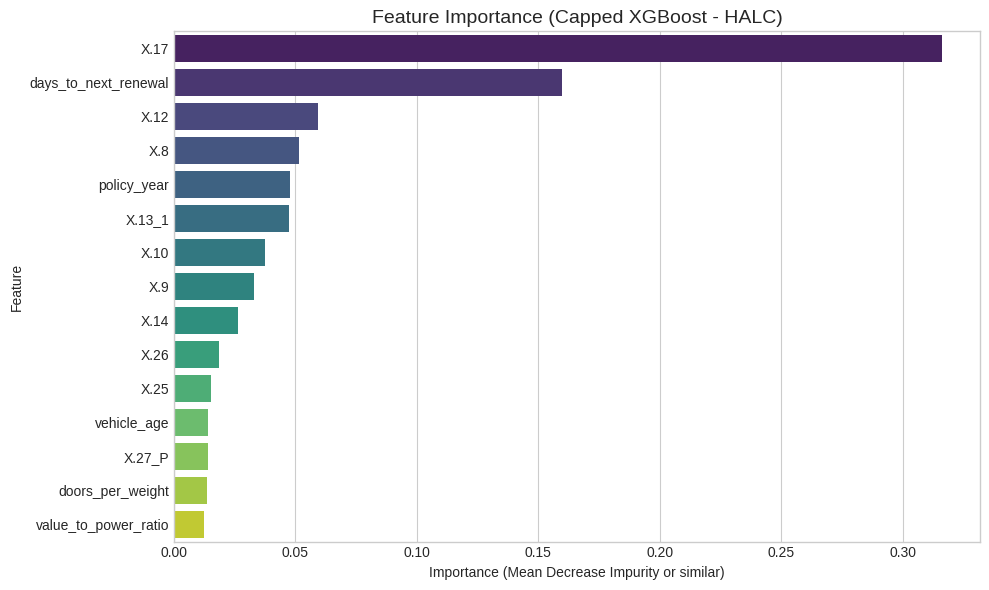


Getting feature importances for Random Forest (CS)...


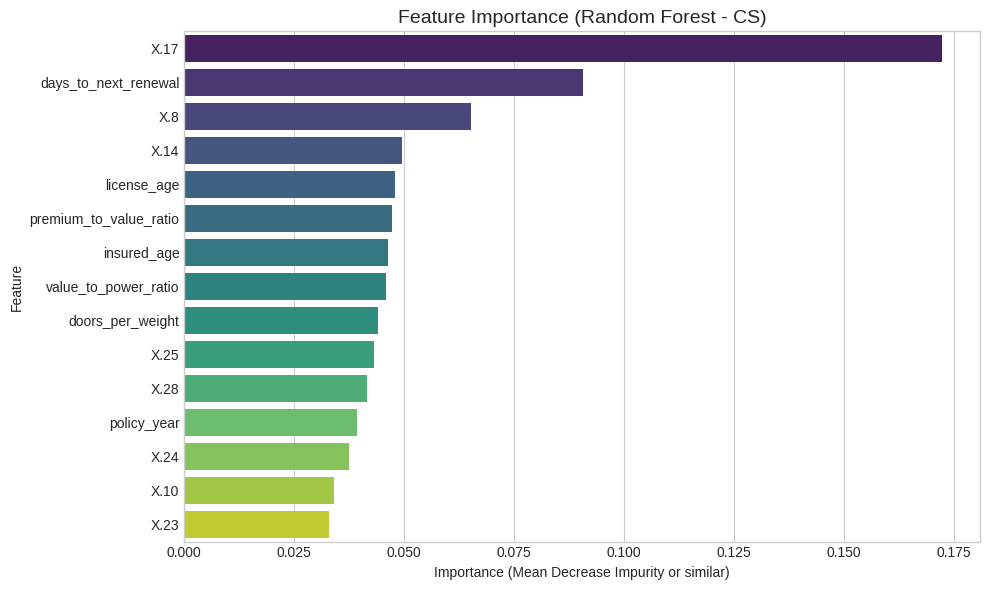


Feature importance analysis complete. Top features:
{'Loss Cost (LC)': ['X.17', 'days_to_next_renewal', 'X.13_1', 'X.12', 'X.8'], 'Historically Adjusted Loss Cost (HALC)': ['X.17', 'days_to_next_renewal', 'X.12', 'X.8', 'policy_year'], 'Claim Status (CS)': ['X.17', 'days_to_next_renewal', 'X.8', 'X.14', 'license_age']}


In [12]:
# Feature Importance Analysis
print("\nFeature Importance Analysis")

# Dictionary to store feature importances and top features for each model
importance_dfs = {}
top_features = {}

# --- Helper function for plotting feature importance ---
def plot_feature_importance(importance_df, title, n_features=15):
    """Plots horizontal bar chart for top N feature importances."""
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(n_features), palette='viridis')
    plt.title(title, fontsize=14)
    plt.xlabel("Importance (Mean Decrease Impurity or similar)", fontsize=10)
    plt.ylabel("Feature", fontsize=10)
    plt.tight_layout()
    plt.show()


# --- Get and Plot Feature Importance for each model ---

# Reference the full processed training features to get column names
# Assuming df_train_final contains the full processed training features (from Step 6)
# Ensure df_train_final is defined before running this cell
try:
    # Assuming df_train_processed is the final processed training dataframe
    df_train_final = df_train_processed.copy()
    X_full_processed_cols = df_train_final.columns
except NameError:
    print("Error: df_train_processed is not defined. Please run the data preprocessing steps first.")
    X_full_processed_cols = None # Set to None to prevent further errors


if X_full_processed_cols is not None:
    # LC Model (Capped XGBoost) - Uses .feature_importances_
    # Ensure xgb_lc_final is defined (from Step 18)
    if 'xgb_lc_final' in locals() and hasattr(xgb_lc_final, 'feature_importances_'):
        print("\nGetting feature importances for Capped XGBoost (LC)...")
        lc_importance = xgb_lc_final.feature_importances_
        lc_importance_df = pd.DataFrame({
            'Feature': X_full_processed_cols, # Use the correct column names
            'Importance': lc_importance
        }).sort_values('Importance', ascending=False)

        importance_dfs['Loss Cost (LC)'] = lc_importance_df
        top_features['Loss Cost (LC)'] = lc_importance_df['Feature'].head(5).tolist() # Store top 5

        plot_feature_importance(lc_importance_df, "Feature Importance (Capped XGBoost - LC)")
    else:
        print("\nCapped XGBoost (LC) model is not defined or does not have feature_importances_ attribute. Please run Step 18.")


    # HALC Model (Capped XGBoost) - Uses .feature_importances_
    # Ensure xgb_halc_final is defined (from Step 18)
    if 'xgb_halc_final' in locals() and hasattr(xgb_halc_final, 'feature_importances_'):
        print("\nGetting feature importances for Capped XGBoost (HALC)...")
        halc_importance = xgb_halc_final.feature_importances_
        halc_importance_df = pd.DataFrame({
            'Feature': X_full_processed_cols, # Use the correct column names
            'Importance': halc_importance
        }).sort_values('Importance', ascending=False)

        importance_dfs['Historically Adjusted Loss Cost (HALC)'] = halc_importance_df
        top_features['Historically Adjusted Loss Cost (HALC)'] = halc_importance_df['Feature'].head(5).tolist() # Store top 5

        plot_feature_importance(halc_importance_df, "Feature Importance (Capped XGBoost - HALC)")
    else:
        print("\nCapped XGBoost (HALC) model is not defined or does not have feature_importances_ attribute. Please run Step 18.")


    # CS Model (Random Forest) - Uses .feature_importances_
    # Ensure rf_cs_final is defined (from Step 18)
    if 'rf_cs_final' in locals() and hasattr(rf_cs_final, 'feature_importances_'):
        print("\nGetting feature importances for Random Forest (CS)...")
        cs_importance = rf_cs_final.feature_importances_
        cs_importance_df = pd.DataFrame({
            'Feature': X_full_processed_cols, # Use the correct column names
            'Importance': cs_importance
        }).sort_values('Importance', ascending=False)

        importance_dfs['Claim Status (CS)'] = cs_importance_df
        top_features['Claim Status (CS)'] = cs_importance_df['Feature'].head(5).tolist() # Store top 5

        plot_feature_importance(cs_importance_df, "Feature Importance (Random Forest - CS)")
    else:
        print("\nRandom Forest (CS) model is not defined or does not have feature_importances_ attribute. Please run Step 18.")


    print("\nFeature importance analysis complete. Top features:")
    print(top_features)
else:
    print("\nFeature importance analysis skipped due to missing data/model dependencies.")

# Summary

## Data Analysis Key Findings

*   The original notebook was successfully refactored into a clean, reproducible pipeline while preserving the modeling choices (XGBoost, LightGBM, Random Forest, Stacking) for predicting LC, HALC, and CS.
*   Preprocessing steps, including date parsing, time feature engineering, target building, ratio feature engineering, and categorical encoding, were consolidated and applied consistently to both training and test data using dedicated functions.
*   Numerical features were scaled and imputed consistently using the training data's median before being used in models.
*   Optional and exploratory models were consolidated into a commented-out archive section to streamline the main modeling pipeline.
*   The final chosen models (Capped XGBoost for LC/HALC and Random Forest for CS) were retrained on the full training dataset.
*   Predictions were successfully generated on the submission test set.
*   Evaluation metrics on a held-out evaluation test set were calculated: LC RMSE (Capped XGB) was 180.38, HALC RMSE (Capped XGB) was 329.10, and CS ROC-AUC (Random Forest) was 0.603.
*   A final submission file (`Prediction.csv`) was generated.
*   Plotting functions were standardized using helper functions.

## Insights or Next Steps

*   The refactored pipeline provides a clear and reproducible process for data loading, preprocessing, modeling, and prediction.
*   Future work could focus on hyperparameter tuning for the final models using cross-validation on the full training set or exploring alternative modeling approaches for the zero-inflated nature of LC and HALC.


# Convert Notebook to PDF

In [13]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-latex-recommended texlive-latex-extra pandoc
!pip install pypandoc

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [14]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/DSO 530/Insurance_Claim_Prediction.ipynb" --output-dir="/content/drive/MyDrive/DSO 530/"

[NbConvertApp] Converting notebook /content/drive/MyDrive/DSO 530/Insurance_Claim_Prediction.ipynb to pdf
[NbConvertApp] Support files will be in Insurance_Claim_Prediction_files/
[NbConvertApp] Making directory ./Insurance_Claim_Prediction_files
[NbConvertApp] Writing 100160 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 289951 bytes to /content/drive/MyDrive/DSO 530/Insurance_Claim_Prediction.pdf
